# Grad-CAM con Pytorch para Explicabilidad Visual
Profesor: Dr. Ing. Rodrigo Salas, Universidad de Valparaíso

[rodrigo.salas@uv.cl](mailto:rodrigo.salas@uv.cl)

Cursillo de Deep Learning aplicado a Imágenes

**Simposio Internacional de Estadística 2025**

**Pasto, Colombia**


En esta actividad aprenderemos a usar Grad-CAM, una técnica de inteligencia artificial explicable, para visualizar qué partes de una imagen contribuyen más a la predicción de un modelo de clasificación. Usaremos DenseNet121 preentrenado en ImageNet y cuatro imágenes locales como ejemplo.

**Recomendación**: crear una copia del notebook para ejecutar el código.

## Librería a utilizar

In [16]:
#pip install grad-cam

In [17]:
# librerías básicas
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Pytorch y modelos preentrenados
from torchvision.transforms import v2 as transforms
from torchvision.transforms import Compose
from torchvision.models import densenet121, DenseNet121_Weights

# Grad-CAM para explicabilidad visual
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

## Configuración de dispositivo

Detectamos si hay una GPU disponible, si no, usamos la CPU

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo en uso:", device)

Dispositivo en uso: cpu


## Carga y visualización de imágenes

Subir previamente las imágenes a archivos de colab

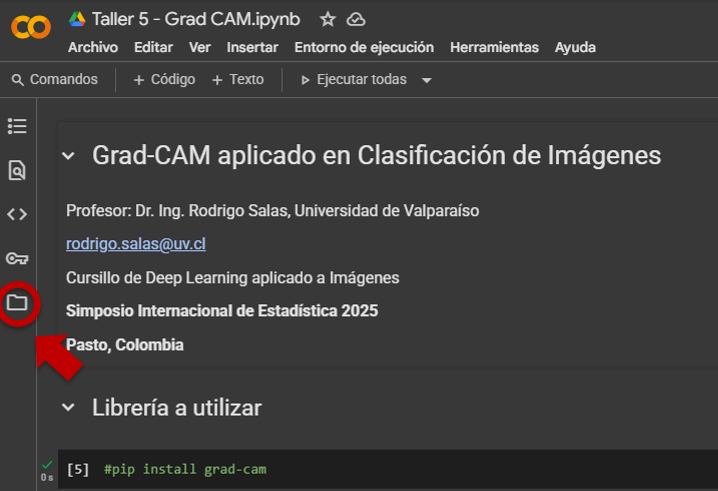

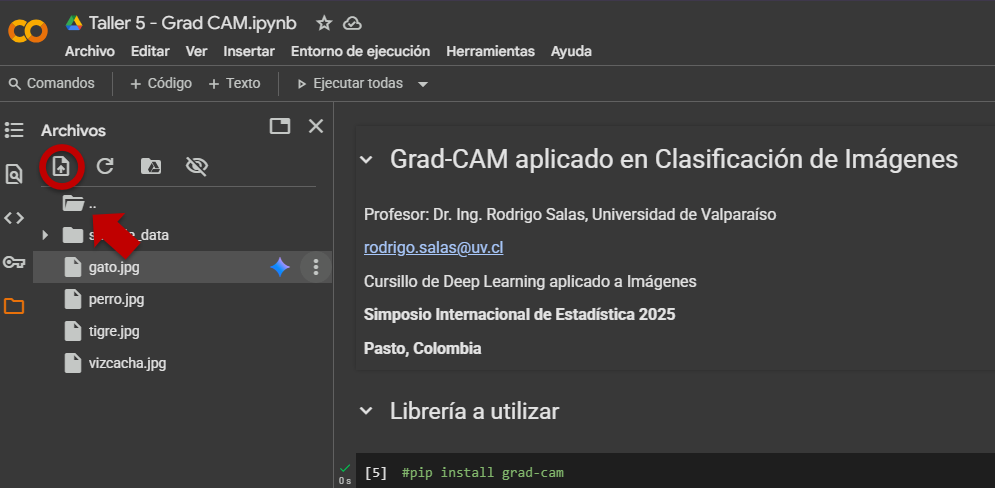

In [19]:
# Rutas de las imágenes
imagenes_paths = [
    "perro.jpg",
    "gato.jpg",
    "vizcacha.jpg",
    "tigre.jpg"]


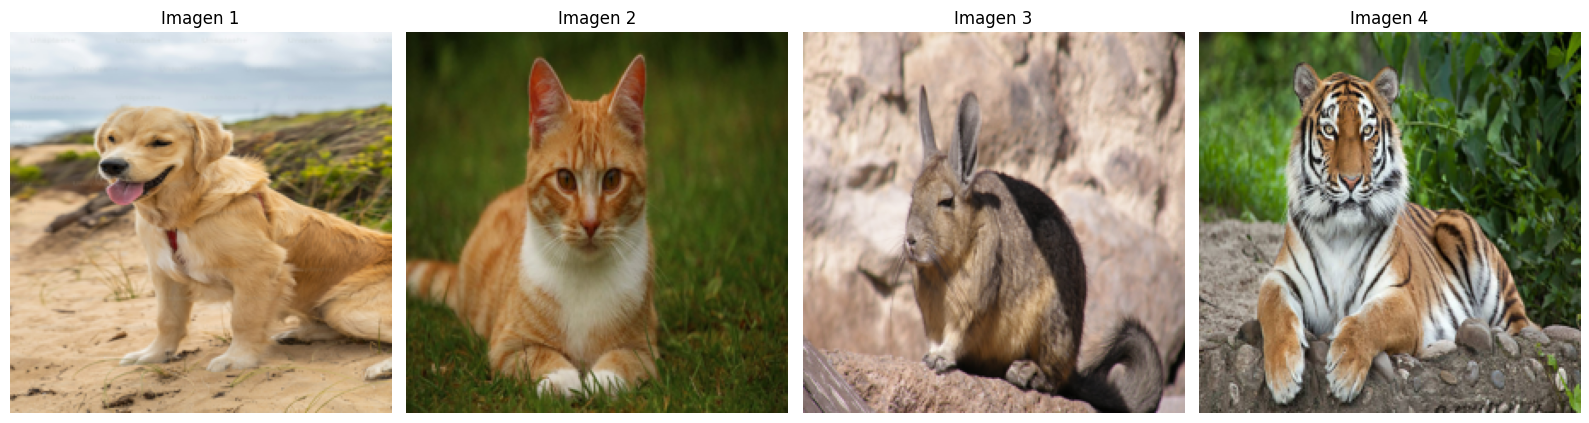

In [25]:
# Mostrar las imágenes cargadas
fig, axs = plt.subplots(1, 4, figsize=(16, 8))
axs = axs.flatten()

for i, path in enumerate(imagenes_paths):
    imagen = Image.open(path).convert("RGB").resize((224, 224))  # conversión a RGB y redimensionamiento
    axs[i].imshow(imagen)
    axs[i].set_title(f"Imagen {i+1}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()

## Transformaciones para el preprocesamiento de las imágenes

Estas transformaciones son necesarias para que las imágenes estén en el formato adecuado para el modelo.

In [21]:
transformaciones = Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),      # Escalamos a [0, 1]
    transforms.Resize((256, 256)),                      # Redimensionamos
    transforms.CenterCrop((224, 224)),                  # Recorte centrado
    transforms.Normalize(mean=[0.485, 0.456, 0.406],    # Normalización
                         std=[0.229, 0.224, 0.225])
])


## Modelo preentrenado DenseNet121

In [22]:
# Cargamos los pesos preentrenados en ImageNet
pesos = DenseNet121_Weights.DEFAULT
modelo = densenet121(weights=pesos).to(device)

# Lo dejamos en modo evaluación, ya que no vamos a entrenar
modelo.eval()

# Etiquetas de clase (como "golden retriever", "tiger", etc.)
labels = pesos.meta["categories"]

## Configuración Grad-CAM

Seleccionamos la última capa convolucional del modelo para aplicar Grad-CAM.

In [23]:
# Usamos la última capa convolucional de DenseNet para generar los mapas de calor
capa_objetivo = [modelo.features[-1]]
cam = GradCAM(model=modelo, target_layers=capa_objetivo)

## Uso de Grad-CAM

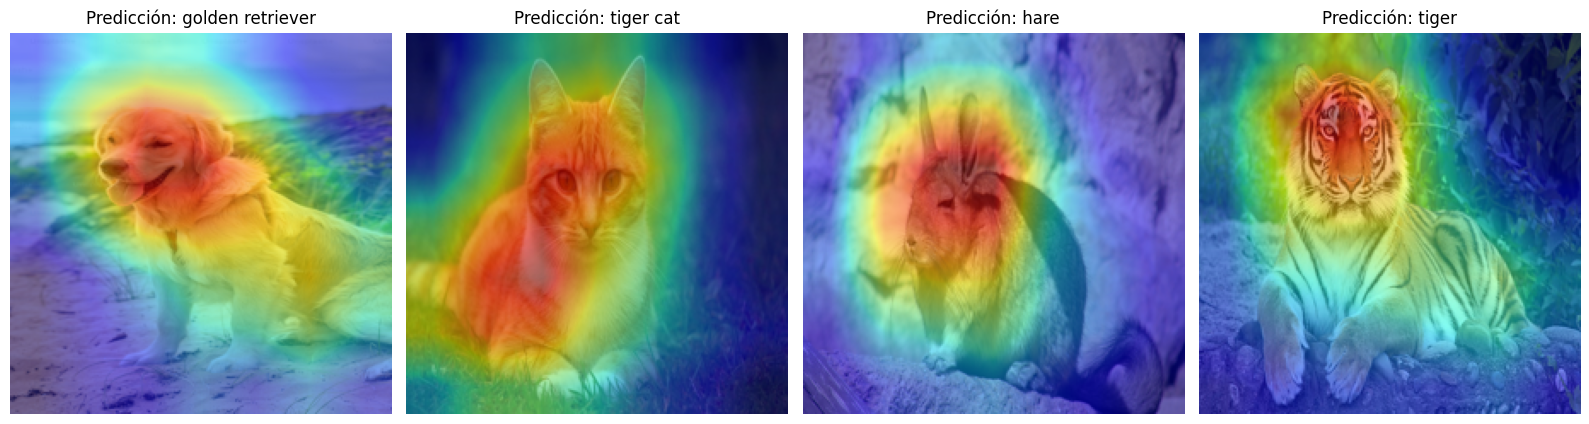

In [24]:
fig, axs = plt.subplots(1, 4, figsize=(16, 8))
axs = axs.flatten()

for i, path in enumerate(imagenes_paths):

    # Cargar imagen original
    imagen = Image.open(path).convert("RGB")
    imagen_redim = imagen.resize((224, 224))

    # Preprocesar la imagen
    tensor_img = transformaciones(imagen).unsqueeze(0).to(device)

    # Realizar predicción del modelo
    with torch.no_grad():
        salida = modelo(tensor_img)
        clase_predicha = salida.argmax(dim=1).item()
        etiqueta = labels[clase_predicha]

    # Generar mapa de calor usando Grad-CAM
    targets = [ClassifierOutputTarget(clase_predicha)]
    heatmap = cam(input_tensor=tensor_img, targets=targets)[0]

    axs[i].imshow(imagen_redim)
    axs[i].imshow(heatmap, alpha=0.5, cmap='jet') # Superponemos Grad-CAM en la imagen original
    axs[i].set_title(f"Predicción: {etiqueta}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()
